<a href="https://colab.research.google.com/github/ambitq/landingPage/blob/main/ml_project_recycle_waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

In [ ]:
# Define the dataset class (modified to include a split parameter)
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# Set the dataset path and hyperparameters
dataset_path = '/kaggle/input/recyclable-and-household-waste-classification/images/images'
batch_size = 32
num_epochs = 5
learning_rate = 0.001

In [ ]:
# Create the datasets and data loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = WasteDataset(dataset_path, split='train', transform=transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Create the model, loss function, and optimizer
num_classes = len(train_dataset.classes)
print(num_classes)
model = CNN(num_classes)
model = nn.DataParallel(model)  # This will use all available GPUs
model = model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

30


In [ ]:
# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")

Epoch [1/5], Train Loss: 3.4234, Val Loss: 2.6468
Epoch [2/5], Train Loss: 2.3151, Val Loss: 1.9170
Epoch [3/5], Train Loss: 1.4939, Val Loss: 1.3941
Epoch [4/5], Train Loss: 0.7115, Val Loss: 1.1734
Epoch [5/5], Train Loss: 0.3520, Val Loss: 1.3833
Training completed!


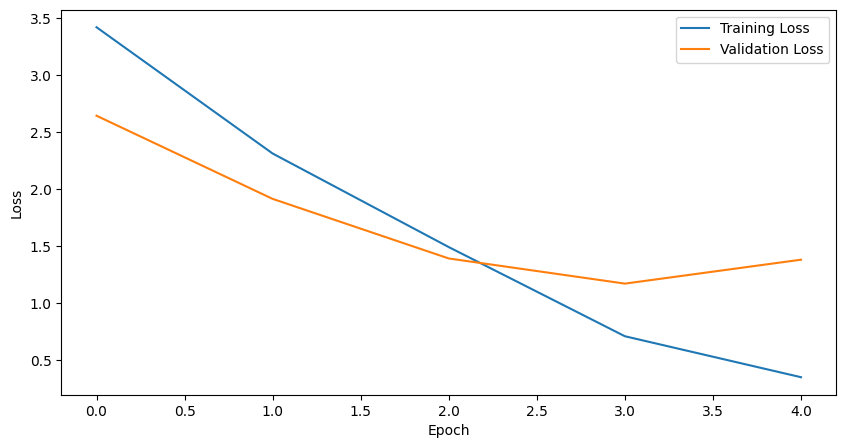

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

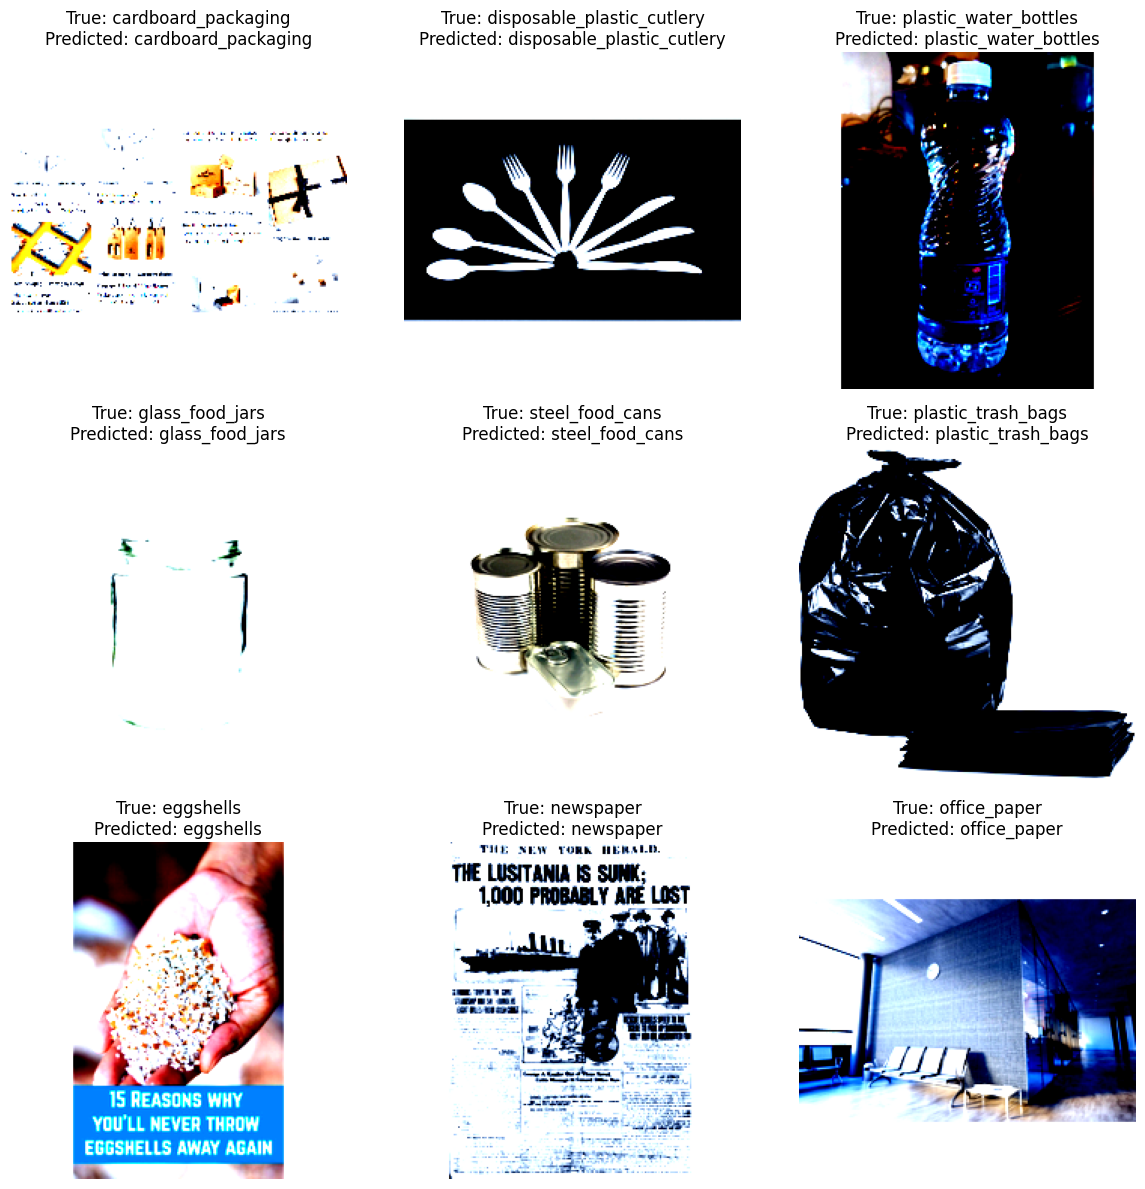

In [ ]:
# Perform sample inferences on random test images with different labels
model.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)

    selected_images = []
    selected_labels = []
    selected_predicted = []

    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')

        output = model(image)
        _, predicted = torch.max(output, 1)

        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())

        if len(selected_labels) == 9:
            break

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        axes[i].set_title(f"True: {train_dataset.classes[selected_labels[i]]}\nPredicted: {train_dataset.classes[selected_predicted[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# Lists to store predictions and true labels
predictions = []
true_labels = []

# No gradient calculation is needed
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

# Calculate F1 score
f1 = f1_score(true_labels, predictions, average='weighted')  # 'weighted' accounts for class imbalance
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.7787
F1 Score: 0.7815


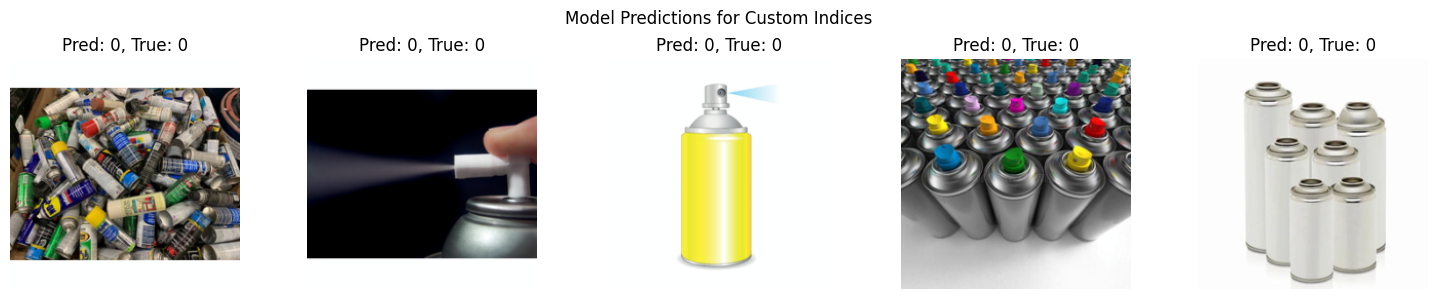

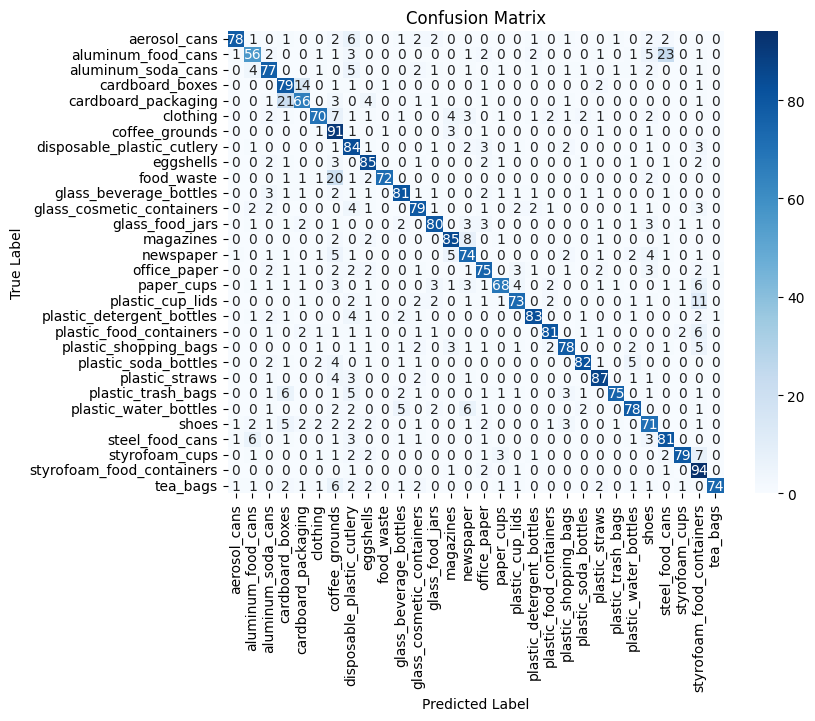

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns
from torchvision import transforms
from PIL import Image
import os

# Assuming the model and data loaders are already defined and trained
# model, test_dataloader, dataset_path, WasteDataset, CNN

# Function to visualize predictions for custom indexed inputs
def visualize_predictions(model, dataset, indices, num_images=5):
    model.eval()  # Set model to evaluation mode
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle('Model Predictions for Custom Indices')

    for i, ax in enumerate(axes):
        idx = indices[i]
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU

        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

        image = image.cpu().numpy().transpose((1, 2, 0))  # Move to CPU and change to HWC
        image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Unnormalize
        image = np.clip(image, 0, 1)  # Clip values to be within [0, 1]

        ax.imshow(image)
        ax.set_title(f'Pred: {predicted_label}, True: {label}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Function to get performance metrics
def get_performance_metrics(model, dataloader):
    model.eval()  # Set model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    cm = confusion_matrix(true_labels, predictions)

    return accuracy, f1, cm, true_labels, predictions


# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

custom_indices = list(range(5))

# 2. Visualize predictions for custom indices
visualize_predictions(model, test_dataset, custom_indices, num_images=5)

# 3. Get performance metrics on the test set
accuracy, f1, cm, true_labels, predictions = get_performance_metrics(model, test_dataloader)


# 5. Plot confusion matrix
classes = test_dataset.classes  # Assuming classes are stored in the dataset
plot_confusion_matrix(cm, classes)

In [ ]:
import torch

# Define the path where you want to save the model
model_save_path = 'waste_classification_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f'Model saved to {model_save_path}')

Model saved to waste_classification_model.pth
